In [64]:
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
# Läs in rådata
df = pd.read_csv('resenorden_data.csv')
print("Datauppsättningens storlek:", df.shape)

Datauppsättningens storlek: (1915, 18)


In [66]:
print("\nFörsta 5 raderna:")
df.head()


Första 5 raderna:


,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,valuta,hotell,bokningskanal,status,avbokningsdatum,recension_text,recensionsdatum,betyg
0,RES-2024-00001,2024-01-08,KUND-05456,Köpenhamn,Danmark,2024-01-13,2024-01-15,2,Weekend-paket,8046.10,SEK,Comfort Hotel Vesterbro,App,Genomförd,NaN,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0
1,RES-2024-00002,2024-01-26,KUND-05456,Rovaniemi,Finland,2024-03-06,2024-03-11,2,All inclusive,34924.80,SEK,Scandic Rovaniemi,Telefon,Klar,NaN,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0
2,RES-2024-00003,2024-01-13,KUND-05177,Rovaniemi,Finland,2024-02-09,2024-02-14,2,Halvpension,26757.60,SEK,Scandic Rovaniemi,App,Genomförd,NaN,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0
3,RES-2024-00004,2024-01-12,KUND-06857,Tromsø,Norge,2024-02-17,2024-02-20,2,Halvpension,2349.80,EUR,Clarion Hotel The Edge,Webb,Genomförd,NaN,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0
4,RES-2024-00005,2024-01-13,KUND-08178,Köpenhamn,Danmark,2024-01-18,2024-01-20,2,Weekend-paket,5289.74,DKK,Comfort Hotel Vesterbro,App,Genomförd,NaN,NaN,NaN,NaN


In [67]:
# Initial utforskning (EDA)
print("DATAÖVERSIKT")
print(f"Antal rader: {df.shape[0]}")
print(f"Antal kolumner: {df.shape[1]}")

DATAÖVERSIKT
Antal rader: 1915
Antal kolumner: 18


In [68]:
print("\nKOLUMNTYPER OCH SAKNADE VÄRDEN ")
df.info()


KOLUMNTYPER OCH SAKNADE VÄRDEN 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bokning_id       1915 non-null   object 
 1   bokningsdatum    1915 non-null   object 
 2   kund_id          1915 non-null   object 
 3   destination      1915 non-null   object 
 4   land             1786 non-null   object 
 5   avresedatum      1915 non-null   object 
 6   hemresedatum     1915 non-null   object 
 7   antal_resenärer  1915 non-null   int64  
 8   pakettyp         1915 non-null   object 
 9   pris             1915 non-null   float64
 10  valuta           1878 non-null   object 
 11  hotell           1840 non-null   object 
 12  bokningskanal    1802 non-null   object 
 13  status           1915 non-null   object 
 14  avbokningsdatum  155 non-null    object 
 15  recension_text   681 non-null    object 
 16  recensionsdatum  681 non-nu

In [69]:
print("SAKNADE VÄRDEN PER KOLUMN")
df.isnull().sum()

SAKNADE VÄRDEN PER KOLUMN


bokning_id            0
bokningsdatum         0
kund_id               0
destination           0
land                129
avresedatum           0
hemresedatum          0
antal_resenärer       0
pakettyp              0
pris                  0
valuta               37
hotell               75
bokningskanal       113
status                0
avbokningsdatum    1760
recension_text     1234
recensionsdatum    1234
betyg              1234
dtype: int64

In [70]:
print(" UNIKA VÄRDEN I VÄLDA KATEGORIKOLUMNER ")
for col in ['destination', 'status', 'pakettyp', 'bokningskanal', 'valuta',]: 
    print(f"\n{col}:")
    print(df[col].value_counts().head(10))

 UNIKA VÄRDEN I VÄLDA KATEGORIKOLUMNER 

destination:
destination
Köpenhamn      592
Oslo           232
Tromsø         163
Reykjavik      163
Helsingfors    136
Rovaniemi      128
Bergen          95
Trondheim       75
Kopenhamn       29
København       24
Name: count, dtype: int64

status:
status
Genomförd    1456
Avbokad       147
Bekräftad     128
Klar           46
GENOMFÖRD      39
Completed      36
genomförd      27
Confirmed       7
OK              6
bekräftad       5
Name: count, dtype: int64

pakettyp:
pakettyp
Weekend-paket    544
Halvpension      425
All inclusive    367
Endast boende    343
WEEKEND-PAKET     21
Helgresa          20
halvpension       16
weekend-paket     16
HP                16
Room Only         15
Name: count, dtype: int64

bokningskanal:
bokningskanal
Webb       864
App        531
Telefon    287
WEBB        17
web         16
Website     12
Online      12
app         11
Mobile      10
APP          9
Name: count, dtype: int64

valuta:
valuta
SEK    1461
EUR   

Anledning: Jag vill se datans grundläggande struktur – vilka kolumner som finns, hur många saknade värden det finns, och unika värden i viktiga kategorikolumner. Detta hjälper mig att identifiera datakvalitetsproblem.

# Problemanalys från EDA
1. Datumkolumner (bokningsdatum, avresedatum, hemresedatum):
   - Olika datumformat (2024-12-14, 2024/12/14, 14 december 2024)
   - Olika separatorer och datumordningar

2. Destination:
   - Samma stad med olika stavningar (Köpenhamn, København, Copenhagen, CPH)
   - Versaler/gemener inkonsekventa

3. Status:
   - Språkblandning (Genomförd, Completed, Confirmed)
   - Olika ord för samma sak (Avbokad, Cancelled, Struken)

4. Pakettyp:
   - Många synonymer (Weekend-paket, WEEKEND-PAKET, Helgresa)
   - Förkortningar (AI, HP, RO)

5. Bokningskanal:
   - Inkonsekventa namn (Webb, web, Website, Online)

6. Saknade värden:
   - land: 129 saknade värden
   - valuta: 37 saknade värden
   - hotell: 75 saknade värden

# Transform – Datatvätt


In [71]:
# Kopiera originaldata för transformation
df_clean = df.copy()
print(f"Originalstorlek: {df_clean.shape}")

Originalstorlek: (1915, 18)


Anledning: Jag skapar en kopia av originaldata för att behålla rådata oröd.

In [105]:
# 2.1 RENSA DATUMKOLUMNER

# Funktion för att standardisera datum (men appliceras direkt)
def clean_date_column(date):
    # Konvertera till sträng, gemener, ta bort mellanslag
    date = date.astype(str).str.lower().str.strip()
    
    # Svenska månader till siffror
    months_map = {
        "januari": "1", "februari": "2", "mars": "3", "april": "4",
        "maj": "5", "juni": "6", "juli": "7", "augusti": "8",
        "september": "9", "oktober": "10", "november": "11", "december": "12"
    }
    
    # Ersätt månadsnamn
    for month_swe, month_num in months_map.items():
        date = date.str.replace(month_swe, month_num, regex=False)
    
    # Konvertera till datetime
    return pd.to_datetime(date, format="mixed", dayfirst=True, errors="coerce")

# Applicera på alla datumkolumner
for col in ['bokningsdatum', 'avresedatum', 'hemresedatum']:
    new_col = f"{col}_clean"
    df_clean[new_col] = clean_date_column(df_clean[col])
    print(f"{col} -> {new_col}: {df_clean[new_col].isnull().sum()} ogiltiga datum")

print("Datum rensade")

bokningsdatum -> bokningsdatum_clean: 0 ogiltiga datum
avresedatum -> avresedatum_clean: 0 ogiltiga datum
hemresedatum -> hemresedatum_clean: 0 ogiltiga datum
Datum rensade


Anledning: Jag skapar en funktion för datumrensning men applicerar den direkt. Detta standardiserar alla datum till samma format, vilket är nödvändigt för korrekt analys.



In [73]:
# 2.2 RENSA DESTINATION

# Normalisera till gemener först
df_clean['destination_clean'] = df_clean['destination'].str.lower().str.strip()

# Mappning för att slå ihop olika stavningar
destination_map = {
    'kopenhamn': 'köpenhamn',
    'københavn': 'köpenhamn',
    'cph': 'köpenhamn',
    'copenhagen': 'köpenhamn',
    'köpnhamn': 'köpenhamn',
    'köpenhman': 'köpenhamn',
    'köpenhamnn': 'köpenhamn',
    'oslö': 'oslo',
    'rey': 'reykjavik',
    'reykavik': 'reykjavik',
    'reykajvik': 'reykjavik',
    'reykjavk': 'reykjavik',
    'reikjavik': 'reykjavik',
    'tromsö': 'tromsø',
    'tromso': 'tromsø',
    'tromsøø': 'tromsø',
    'hfors': 'helsingfors',
    'helsingfross': 'helsingfors',
    'helsingfor': 'helsingfors',
    'rovaniem': 'rovaniemi',
    'tronheim': 'trondheim'
}

# Applicera mappningen
df_clean['destination_clean'] = df_clean['destination_clean'].replace(destination_map)

print("Unika destinationer efter rensning:")
print(df_clean['destination_clean'].value_counts())
print(f"\nAntal unika destinationer före: {df['destination'].nunique()}")
print(f"Antal unika destinationer efter: {df_clean['destination_clean'].nunique()}")



Unika destinationer efter rensning:
destination_clean
köpenhamn      726
oslo           265
tromsø         203
reykjavik      189
helsingfors    159
rovaniemi      156
bergen         108
trondheim       96
helsinki        10
reykjavík        3
Name: count, dtype: int64

Antal unika destinationer före: 39
Antal unika destinationer efter: 10


Anledning: Destination har många stavningsvarianter. Genom att mappa dem till standardnamn minskar vi antalet kategorier.

In [74]:
# FYLL I SAKNADE LAND BASERAT PÅ DESTINATION

# Först, normalisera befintliga land-värden
df_clean['land'] = df_clean['land'].astype(str).str.strip().str.capitalize()

# Mappning från destination till land
destination_to_land = {
    'köpenhamn': 'Danmark',
    'oslo': 'Norge',
    'reykjavik': 'Island',
    'tromsø': 'Norge',
    'helsingfors': 'Finland',
    'rovaniemi': 'Finland',
    'trondheim': 'Norge',
    'bergen': 'Norge',
    'helsinki': 'Finland'
}

# Fyll i saknade värden
missing_land_mask = (df_clean['land'].isnull()) | (df_clean['land'] == 'Nan')
df_clean.loc[missing_land_mask, 'land'] = df_clean.loc[missing_land_mask, 'destination_clean'].map(
    lambda x: destination_to_land.get(x, 'Okänt')
)

print(f"\nSaknade land före: {df['land'].isnull().sum()}")
print(f"Saknade land efter: {df_clean['land'].isnull().sum()}")


Saknade land före: 129
Saknade land efter: 0


Anledning: Många rader saknar land, men vi kan koppla landet från destinationen.



In [75]:
# RENSA STATUS

# Normalisera först
df_clean['status_clean'] = df_clean['status'].str.lower().str.strip()

# Mappning till två huvudkategorier
status_map = {
    'genomförd': 'bekräftad',
    'klar': 'bekräftad',
    'completed': 'bekräftad',
    'confirmed': 'bekräftad',
    'ok': 'bekräftad',
    'bokad': 'bekräftad',
    'bokat': 'bekräftad',
    'conf': 'bekräftad',
    'färdig': 'bekräftad',
    'done': 'bekräftad',
    'struken': 'avbokad',
    'avbokad': 'avbokad',
    'avbeställd': 'avbokad',
    'cancelled': 'avbokad',
    'canceled': 'avbokad'
}

# Applicera mappning
df_clean['status_clean'] = df_clean['status_clean'].replace(status_map)

print("\nStatus före rensning:")
print(df['status'].value_counts().head())
print("\nStatus efter rensning:")
print(df_clean['status_clean'].value_counts())


Status före rensning:
status
Genomförd    1456
Avbokad       147
Bekräftad     128
Klar           46
GENOMFÖRD      39
Name: count, dtype: int64

Status efter rensning:
status_clean
bekräftad    1757
avbokad       158
Name: count, dtype: int64


Anledning: Status har många varianter som egentligen betyder samma sak. Så vi reducera de  till två huvudkategorier ("bekräftad" och "avbokad").

In [76]:
# RENSA PAKETTYP

df_clean['pakettyp_clean'] = df_clean['pakettyp'].str.lower().str.strip()

pakettyp_map = {
    'weekend-paket': 'weekend-paket',
    'weekend paket': 'weekend-paket',
    'weekend': 'weekend-paket',
    'helgresa': 'weekend-paket',
    'helgpaket': 'weekend-paket',
    'kortresa': 'weekend-paket',
    'halvpension': 'halvpension',
    'hp': 'halvpension',
    'half board': 'halvpension',
    'all-inclusive': 'all-inclusive',
    'all inclusive': 'all-inclusive',
    'all inkl': 'all-inclusive',
    'ai': 'all-inclusive',
    'allt ingår': 'all-inclusive',
    'full board': 'all-inclusive',
    'fb': 'all-inclusive',
    'endast-boende': 'endast-boende',
    'endast boende': 'endast-boende',
    'bara hotell': 'endast-boende',
    'room only': 'endast-boende',
    'ro': 'endast-boende',
    'b&b': 'endast-boende',
    'bed & breakfast': 'endast-boende'
}

df_clean['pakettyp_clean'] = df_clean['pakettyp_clean'].replace(pakettyp_map)

print("\nPakettyp före rensning:")
print(df['pakettyp'].value_counts().head(10))
print("\nPakettyp efter rensning:")
print(df_clean['pakettyp_clean'].value_counts())


Pakettyp före rensning:
pakettyp
Weekend-paket    544
Halvpension      425
All inclusive    367
Endast boende    343
WEEKEND-PAKET     21
Helgresa          20
halvpension       16
weekend-paket     16
HP                16
Room Only         15
Name: count, dtype: int64

Pakettyp efter rensning:
pakettyp_clean
weekend-paket    624
halvpension      481
all-inclusive    409
endast-boende    401
Name: count, dtype: int64


Anledning: Liksom med status har pakettyp många synonymer. Så vi standardisera de  till 4 huvudkategorier.

In [77]:
# RENSA BOKNINGSKANAL

df_clean['bokningskanal_clean'] = df_clean['bokningskanal'].str.lower().str.strip()

bokningskanal_map = {
    'webb': 'website',
    'web': 'website',
    'website': 'website',
    'online': 'website',
    'internet': 'website',
    'app': 'app',
    'telefon': 'telefon',
    'phone': 'telefon',
    'tel': 'telefon',
    'mobil': 'telefon',
    'mobile': 'telefon',
    'ring': 'telefon'
}

df_clean['bokningskanal_clean'] = df_clean['bokningskanal_clean'].replace(bokningskanal_map)

print("\nBokningskanal före rensning:")
print(df['bokningskanal'].value_counts().head(10))
print("\nBokningskanal efter rensning:")
print(df_clean['bokningskanal_clean'].value_counts())


Bokningskanal före rensning:
bokningskanal
Webb       864
App        531
Telefon    287
WEBB        17
web         16
Website     12
Online      12
app         11
Mobile      10
APP          9
Name: count, dtype: int64

Bokningskanal efter rensning:
bokningskanal_clean
website    928
app        551
telefon    323
Name: count, dtype: int64


Anledning: Bokningskanal har också många varianter. Så vi standardisera de till tre kanaler (website, app, telefon).

In [78]:
# VALUTAKONVERTERING TILL SEK

# Normalisera valuta först
df_clean['valuta_clean'] = df_clean['valuta'].str.lower().str.strip()

# Valutakurser
valuta_map = {
    'sek': 1.0,
    'eur': 11.3,
    'nok': 0.95,
    'dkk': 1.52
}

# Konvertera till SEK
df_clean['pris_sek'] = df_clean.apply(
    lambda row: row['pris'] * valuta_map.get(row['valuta_clean'], 1.0),
    axis=1
)

# Fyll i saknade valutor med "okänt"
df_clean['valuta'] = df_clean['valuta'].fillna('okänt')

print(f"\nValutor före rensning: {df['valuta'].unique()}")
print(f"Valutor efter rensning: {df_clean['valuta_clean'].unique()}")
print(f"\nPris i SEK skapat. Exempelvärden:")
print(df_clean[['pris', 'valuta_clean', 'pris_sek']].head())


Valutor före rensning: ['SEK' 'EUR' 'DKK' 'NOK' nan]
Valutor efter rensning: ['sek' 'eur' 'dkk' 'nok' nan]

Pris i SEK skapat. Exempelvärden:
       pris valuta_clean    pris_sek
0   8046.10          sek   8046.1000
1  34924.80          sek  34924.8000
2  26757.60          sek  26757.6000
3   2349.80          eur  26552.7400
4   5289.74          dkk   8040.4048


Anledning: Priser i olika valutor gör det svårt att jämföra. Genom att konvertera alla till SEK skapar vi en enhetlig valuta för analys.

In [79]:
# FILL I SAKNADE VÄRDEN I ÖVRIGA KOLUMNER

# Hotell: sätt till "okänt" för saknade värden
df_clean['hotell'] = df_clean['hotell'].fillna('okänt')

# Recensioner: sätt tom sträng för saknade
df_clean['recension_text'] = df_clean['recension_text'].fillna('')

print("\nSLUTSTATUS FÖR SAKNADE VÄRDEN")
print(df_clean.isnull().sum())
print(f"\nTotalt antal rader efter rensning: {len(df_clean)}")
print(f"Antal rader med helt kompletta data: {len(df_clean.dropna())}")


SLUTSTATUS FÖR SAKNADE VÄRDEN
bokning_id                0
bokningsdatum             0
kund_id                   0
destination               0
land                      0
avresedatum               0
hemresedatum              0
antal_resenärer           0
pakettyp                  0
pris                      0
valuta                    0
hotell                    0
bokningskanal           113
status                    0
avbokningsdatum        1760
recension_text            0
recensionsdatum        1234
betyg                  1234
bokningsdatum_clean       0
avresedatum_clean         0
hemresedatum_clean        0
destination_clean         0
status_clean              0
pakettyp_clean            0
bokningskanal_clean     113
valuta_clean             37
pris_sek                  0
dtype: int64

Totalt antal rader efter rensning: 1915
Antal rader med helt kompletta data: 1


Anledning: Jag fyller i de sista saknade värdena med lämpliga standardvärden för att undvika problem i analysen.

# data dictionary

1. bokningsdatum_clean , avresedatum_clean, hemresedatum_clean:
   - beskrivning: Rensat bokningsdatum i datetime-format
   - datatyp: datetime64[ns]
   - status: ny kolumn
   - kommentar: Jag skapar en funktion för datumrensning men applicerar den direkt. Detta standardiserar alla datum till samma format, vilket är nödvändigt för korrekt analys.

2. destination_clean:
   - beskrivning: Standardiserad destination
   - datatyp: object
   - status: ny kolumn
   - kommentar: Destination har många stavningsvarianter. Genom att mappa dem till standardnamn minskar vi antalet kategorier.

3. land: 
   - beskriving: kopplat land utifrån destination 
   - datatyp: object
   - status: ny kolumn 
   - kommentar: Många rader saknar land, men vi kan koppla landet från destinationen.

4. status_clean: 
   - beskriving: Standardiserad status 
   - datatyp: object 
   - status: ny kolumn 
   - komentar: Status har många varianter som egentligen betyder samma sak. Så vi reducera de  till två huvudkategorier ("bekräftad" och "avbokad").

5. pakettyp_clean:
   - beskrivning: Standardiserad paketyp 
   - datatyp: object 
   - status: ny kolumn 
   - komentar: Liksom med status har pakettyp många synonymer. Så vi standardisera de  till 4 huvudkategorier.

6. bokningskanal_clean: 
   - beskriving: Standardiserad bokningskanal
   - datatyp: object 
   - status: ny kolumn 
   - komentar: Bokningskanal har också många varianter. Så vi standardisera de till tre kanaler (website, app, telefon).

7. valuta_clean:
   - beskrivng: valutakonverterung till sek 
   - datatyp: float
   - status: ny kolumn 
   - beskriving: Fyll i saknade valutor med "okänt". Priser i olika valutor gör det svårt att jämföra. Genom att konvertera alla till SEK skapar vi en enhetlig valuta för analys.

8. övrigt: 
   - fill i saknade värden i övriga kolumner 
   - Hotell: sätt till "okänt" för saknade värden
   - Recensioner: sätt tom sträng för saknade
   - Jag fyller i de sista saknade värdena med lämpliga standardvärden för att undvika problem i analysen.

## Feature Engineering
Nya kolumner skapas för att möjliggöra analys. 

In [87]:
# Först: Konvertera alla datumkolumner till datetime
date_columns = ['bokningsdatum_clean', 'avresedatum_clean', 'hemresedatum_clean']

for col in date_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        print(f"{col}: {df_clean[col].isnull().sum()} ogiltiga datum efter konvertering")

bokningsdatum_clean: 0 ogiltiga datum efter konvertering
avresedatum_clean: 0 ogiltiga datum efter konvertering
hemresedatum_clean: 0 ogiltiga datum efter konvertering


In [89]:
# BERÄKNA LEDTIDER OCH RESLÄNGD

df_clean['ledtid_dagar'] = (df_clean['avresedatum_clean'] - df_clean['bokningsdatum_clean']).dt.days
df_clean['reslängd_dagar'] = (df_clean['hemresedatum_clean'] - df_clean['avresedatum_clean']).dt.days
df_clean['vecka_bokning'] = df_clean['bokningsdatum_clean'].dt.isocalendar().week
df_clean['manad_bokning'] = df_clean['bokningsdatum_clean'].dt.month

Anledning: Dessa nya features lägger till värdefull information för analys:

Ledtid visar hur långt i förväg folk bokar

Reslängd hjälper oss förstå typiska resor

Datumfeatures möjliggör analys av säsongsmönster

In [91]:
# Visa första 10 raderna med alla kolumner
df_clean.head(10)

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,pakettyp_clean,bokningskanal_clean,valuta_clean,pris_sek,ledtid_dagar,reslängd_dagar,vecka_bokning,manad_bokning,ledtid_kategori,reslängd_kategori
0,RES-2024-00001,2024-01-08,KUND-05456,Köpenhamn,Danmark,2024-01-13,2024-01-15,2,Weekend-paket,8046.10,...,weekend-paket,app,sek,8046.1000,5,2,2,1,Sista minuten (≤1 vecka),Kortresa (≤3 dagar)
1,RES-2024-00002,2024-01-26,KUND-05456,Rovaniemi,Finland,2024-03-06,2024-03-11,2,All inclusive,34924.80,...,all-inclusive,telefon,sek,34924.8000,40,5,4,1,Mellanlång (1-3 månader),Veckoresa (4-7 dagar)
2,RES-2024-00003,2024-01-13,KUND-05177,Rovaniemi,Finland,2024-02-09,2024-02-14,2,Halvpension,26757.60,...,halvpension,app,sek,26757.6000,27,5,2,1,Kort (1-4 veckor),Veckoresa (4-7 dagar)
3,RES-2024-00004,2024-01-12,KUND-06857,Tromsø,Norge,2024-02-17,2024-02-20,2,Halvpension,2349.80,...,halvpension,website,eur,26552.7400,36,3,2,1,Mellanlång (1-3 månader),Kortresa (≤3 dagar)
4,RES-2024-00005,2024-01-13,KUND-08178,Köpenhamn,Danmark,2024-01-18,2024-01-20,2,Weekend-paket,5289.74,...,weekend-paket,app,dkk,8040.4048,5,2,2,1,Sista minuten (≤1 vecka),Kortresa (≤3 dagar)
5,RES-2024-00006,2024-01-18,KUND-05585,Oslo,Norge,2024-03-10,2024-03-14,2,ALL INCLUSIVE,34038.00,...,all-inclusive,telefon,nok,32336.1000,52,4,3,1,Mellanlång (1-3 månader),Veckoresa (4-7 dagar)
6,RES-2024-00007,2024-01-14,KUND-08527,Köpenhamn,Danmark,2024-02-10,2024-02-13,2,Endast boende,1165.02,...,endast-boende,website,eur,13164.7260,27,3,2,1,Kort (1-4 veckor),Kortresa (≤3 dagar)
7,RES-2024-00008,2024-01-09,KUND-05469,HELSINGFORS,Finland,2024-02-27,2024-03-03,2,Halvpension,15127.20,...,halvpension,website,sek,15127.2000,49,5,2,1,Mellanlång (1-3 månader),Veckoresa (4-7 dagar)
8,RES-2024-00009,2024-01-10,KUND-08120,Köpenhamn,Danmark,2024-01-27,2024-01-29,2,Weekend-paket,9559.10,...,weekend-paket,website,sek,9559.1000,17,2,2,1,Kort (1-4 veckor),Kortresa (≤3 dagar)
9,RES-2024-00010,2024-01-03,KUND-08178,Reykjavik,Island,2024-02-14,2024-02-17,3,Weekend-paket,23583.00,...,weekend-paket,telefon,sek,23583.0000,42,3,1,1,Mellanlång (1-3 månader),Kortresa (≤3 dagar)


In [83]:
# SKAPA KATEGORIER BASERAT PÅ VÄRDEN

# Kategorisera ledtid
def kategorisera_ledtid(dagar):
    if dagar < 0:
        return 'Ogiltig'
    elif dagar <= 7:
        return 'Sista minuten (≤1 vecka)'
    elif dagar <= 30:
        return 'Kort (1-4 veckor)'
    elif dagar <= 90:
        return 'Mellanlång (1-3 månader)'
    else:
        return 'Lång (3+ månader)'

df_clean['ledtid_kategori'] = df_clean['ledtid_dagar'].apply(kategorisera_ledtid)

# Kategorisera reslängd
def kategorisera_reslängd(dagar):
    if dagar <= 3:
        return 'Kortresa (≤3 dagar)'
    elif dagar <= 7:
        return 'Veckoresa (4-7 dagar)'
    elif dagar <= 14:
        return 'Mellanlång (1-2 veckor)'
    else:
        return 'Långresa (2+ veckor)'

df_clean['reslängd_kategori'] = df_clean['reslängd_dagar'].apply(kategorisera_reslängd)

print("\n KATEGORIER ")
print("Ledtidskategorier:")
print(df_clean['ledtid_kategori'].value_counts())
print("\nReslängdskategorier:")
print(df_clean['reslängd_kategori'].value_counts())


 KATEGORIER 
Ledtidskategorier:
ledtid_kategori
Mellanlång (1-3 månader)    889
Kort (1-4 veckor)           809
Sista minuten (≤1 vecka)    187
Ogiltig                      28
Lång (3+ månader)             2
Name: count, dtype: int64

Reslängdskategorier:
reslängd_kategori
Kortresa (≤3 dagar)      1044
Veckoresa (4-7 dagar)     869
Långresa (2+ veckor)        2
Name: count, dtype: int64


Anledning: Kategorisering gör det enklare att analysera mönster. Istället för att titta på exakta antal dagar kan vi nu analysera trender för "sista minuten"-bokningar vs "långsiktiga" bokningar.

## Sentimentanalys av kundrecensioner
Recensioner klassificeras som positiva, neutrala eller negativa.

In [84]:
# Importera bibliotek
import torch
from transformers import pipeline
df = pd.read_csv("output/resenorden_cleaned.csv")


# Kolla GPU-status
print("GPU tillgänglig:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

GPU tillgänglig: False


In [92]:
# Ladda den svenska sentiment-modellen
classifier = pipeline(
    "sentiment-analysis",
    model="KBLab/robust-swedish-sentiment-multiclass",
    device=0 if torch.cuda.is_available() else -1
)


# Testa att modellen fungerar
test_result = classifier("Det här var toppen!")
print("Testresultat:", test_result)

Device set to use cpu


Testresultat: [{'label': 'POSITIVE', 'score': 0.996466875076294}]


In [ ]:
feedback_list =  (
    df["recension_text"]
    .fillna("")
    .astype(str)
    .tolist()
) #Take all the feedback from your table (df).
  #Make it into a list of text so the classifier can read it.


results = classifier(feedback_list) 
#Ask the classifier to read each feedback and decide its label.
#It gives a list of answers, each answer looks like:
#{"label": "POSITIVE", "score": 0.98}


df['predicted_label'] = [r['label'] for r in results] 
# Take the labels from the classifier results.#Make a new column in your table called predicted_label.


df['predicted_score'] = [r['score'] for r in results]
#Take the confidence scores from the classifier results.
#Make a new column in your table called predicted_score.

#Visa de första 10
df.head(2)


KeyboardInterrupt: 

In [ ]:
df['match'] = df['predicted_label'] == df['recension_text']
accuracy = df['match'].mean()
print(f"Andel korrekta: {accuracy:.1%}")
df.head(5)

Andel korrekta: 0.0%


,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,recension_text,recensionsdatum,betyg,status_clean,destination_clean,pakettyp_clean,bokningskanal_clean,predicted_label,predicted_score,match
0,RES-2024-00001,2024-01-08,KUND-05456,Köpenhamn,danmark,2024-01-13,2024-01-15,2,Weekend-paket,8046.10,...,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0,bekräftad,köpenhamn,weekend-paket,app,NEUTRAL,0.607957,False
1,RES-2024-00002,2024-01-26,KUND-05456,Rovaniemi,finland,2024-03-06,2024-03-11,2,All inclusive,34924.80,...,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0,bekräftad,rovaniemi,all-inclusive,telefon,POSITIVE,0.984900,False
2,RES-2024-00003,2024-01-13,KUND-05177,Rovaniemi,finland,2024-02-09,2024-02-14,2,Halvpension,26757.60,...,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0,bekräftad,rovaniemi,halvpension,app,POSITIVE,0.996892,False
3,RES-2024-00004,2024-01-12,KUND-06857,Tromsø,norge,2024-02-17,2024-02-20,2,Halvpension,2349.80,...,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0,bekräftad,tromsø,halvpension,website,POSITIVE,0.990417,False
4,RES-2024-00005,2024-01-13,KUND-08178,Köpenhamn,danmark,2024-01-18,2024-01-20,2,Weekend-paket,5289.74,...,NaN,NaN,NaN,bekräftad,köpenhamn,weekend-paket,app,NEUTRAL,0.968194,False


In [93]:
mismatches = df[~df['match']].copy()
print(f"Antal som inte matchade: {len(mismatches)}")
mismatches[['recension_text', 'predicted_label', 'predicted_score']]

KeyError: 'match'

# Pipeline-funktioner

In [106]:
# FUNKTIONER FÖR DATATVÄTT

def clean_date_column(series):
    #Standardisera datumkolumner
    series = series.astype(str).str.lower().str.strip()
    
    months_map = {
        "januari": "1", "februari": "2", "mars": "3", "april": "4",
        "maj": "5", "juni": "6", "juli": "7", "augusti": "8",
        "september": "9", "oktober": "10", "november": "11", "december": "12"
    }
    
    for month_swe, month_num in months_map.items():
        series = series.str.replace(month_swe, month_num, regex=False)
    
    return pd.to_datetime(series, format="mixed", dayfirst=True, errors="coerce")

def clean_destination(df):
    #Rensa destination-kolumnen
    df = df.copy()
    df['destination_clean'] = df['destination'].str.lower().str.strip()
    
    destination_map = {
        'kopenhamn': 'köpenhamn', 'københavn': 'köpenhamn', 'cph': 'köpenhamn',
        'copenhagen': 'köpenhamn', 'köpnhamn': 'köpenhamn', 'köpenhman': 'köpenhamn',
        'köpenhamnn': 'köpenhamn', 'oslö': 'oslo', 'rey': 'reykjavik',
        'reykavik': 'reykjavik', 'reykajvik': 'reykjavik', 'reykjavk': 'reykjavik',
        'reikjavik': 'reykjavik', 'tromsö': 'tromsø', 'tromso': 'tromsø',
        'tromsøø': 'tromsø', 'hfors': 'helsingfors', 'helsingfross': 'helsingfors',
        'helsingfor': 'helsingfors', 'rovaniem': 'rovaniemi', 'tronheim': 'trondheim'
    }
    
    df['destination_clean'] = df['destination_clean'].replace(destination_map)
    return df

def clean_status(df):
    #Rensa status-kolumnen
    df = df.copy()
    df['status_clean'] = df['status'].str.lower().str.strip()
    
    status_map = {
        'genomförd': 'bekräftad', 'klar': 'bekräftad', 'completed': 'bekräftad',
        'confirmed': 'bekräftad', 'ok': 'bekräftad', 'bokad': 'bekräftad',
        'bokat': 'bekräftad', 'conf': 'bekräftad', 'färdig': 'bekräftad',
        'done': 'bekräftad', 'struken': 'avbokad', 'avbokad': 'avbokad',
        'avbeställd': 'avbokad', 'cancelled': 'avbokad', 'canceled': 'avbokad'
    }
    
    df['status_clean'] = df['status_clean'].replace(status_map)
    return df


    #Huvudfunktion för att transformera data
def transform_data(df):
    df = df.copy()
    
    # Rensa datum
    for col in ['bokningsdatum', 'avresedatum', 'hemresedatum']:
        df[f"{col}_clean"] = clean_date_column(df[col])
    
    # Rensa kategorier
    df = clean_destination(df)
    df = clean_status(df)
    
    # Fyll i saknade land
    df['land'] = df['land'].astype(str).str.strip().str.capitalize()
    destination_to_land = {
        'köpenhamn': 'Danmark', 'oslo': 'Norge', 'reykjavik': 'Island',
        'tromsø': 'Norge', 'helsingfors': 'Finland', 'rovaniemi': 'Finland',
        'trondheim': 'Norge', 'bergen': 'Norge', 'helsinki': 'Finland'
    }
    missing_land = (df['land'].isnull()) | (df['land'] == 'Nan')
    df.loc[missing_land, 'land'] = df.loc[missing_land, 'destination_clean'].map(
        lambda x: destination_to_land.get(x, 'Okänt')
    )
    
    # Valutakonvertering
    df['valuta_clean'] = df['valuta'].str.lower().str.strip()
    valuta_map = {'sek': 1.0, 'eur': 11.3, 'nok': 0.95, 'dkk': 1.52}
    df['pris_sek'] = df.apply(
        lambda row: row['pris'] * valuta_map.get(row['valuta_clean'], 1.0),
        axis=1
    )
    
    # Feature engineering
    df['ledtid_dagar'] = (df['avresedatum_clean'] - df['bokningsdatum_clean']).dt.days
    df['reslängd_dagar'] = (df['hemresedatum_clean'] - df['avresedatum_clean']).dt.days
    df['vecka_bokning'] = df['bokningsdatum_clean'].dt.isocalendar().week
    df['manad_bokning'] = df['bokningsdatum_clean'].dt.month    
    return df

print("Pipeline-funktioner skapade!")

Pipeline-funktioner skapade!


Anledning: Nu skapar jag funktioner som gör hela processen återanvändbar. Detta är viktigt för:

Återanvändning på ny data

Validering - vi kan testa på valideringsdata

Underhåll - lättare att uppdatera och felsöka

# Load – Spara till SQLite


In [116]:
# SPARA TILL SQLITE

def load_to_sqlite(df, db_path="resenorden.db", table_name="orders_cleaned"):
    # Spara DataFrame till SQLite-databas
    # Skapa koppling
    engine = create_engine(f"sqlite:///{db_path}")
    
    # Spara till databas
    df.to_sql(table_name, engine, if_exists="replace", index=False)
    
    print(f"Data sparad till {db_path} i tabellen {table_name}")
    print(f"Antal rader: {len(df)}")
    print(f"Antal kolumner: {len(df.columns)}")
    
    return engine

# Spara vår rensade data
engine = load_to_sqlite(df_clean)

Data sparad till resenorden.db i tabellen orders_cleaned
Antal rader: 1915
Antal kolumner: 33


In [115]:
# VERIFIERA ATT DATA LADDATS KORREKT

def verify_load(db_path="resenorden.db", table_name="orders_cleaned"):
    #Verifiera att datan laddats korrekt
    # Anslut till databasen
    conn = sqlite3.connect(db_path)
    
    # Hämta lite data för att verifiera
    df_loaded = pd.read_sql(f"SELECT * FROM {table_name} LIMIT 5", conn)

    
    # Stäng anslutningen
    conn.close()
    
    print("VERIFIERING AV LADDAD DATA")
    print(f"\nFörsta 5 raderna från {table_name}:")
    print(df_loaded)
    
    
    return df_loaded

# Kör verifieringen
df_loaded = verify_load()

VERIFIERING AV LADDAD DATA

Första 5 raderna från orders_cleaned:
       bokning_id bokningsdatum     kund_id destination     land avresedatum  \
0  RES-2024-00001    2024-01-08  KUND-05456   Köpenhamn  Danmark  2024-01-13   
1  RES-2024-00002    2024-01-26  KUND-05456   Rovaniemi  Finland  2024-03-06   
2  RES-2024-00003    2024-01-13  KUND-05177   Rovaniemi  Finland  2024-02-09   
3  RES-2024-00004    2024-01-12  KUND-06857      Tromsø    Norge  2024-02-17   
4  RES-2024-00005    2024-01-13  KUND-08178   Köpenhamn  Danmark  2024-01-18   

  hemresedatum  antal_resenärer       pakettyp      pris  ... pakettyp_clean  \
0   2024-01-15                2  Weekend-paket   8046.10  ...  weekend-paket   
1   2024-03-11                2  All inclusive  34924.80  ...  all-inclusive   
2   2024-02-14                2    Halvpension  26757.60  ...    halvpension   
3   2024-02-20                2    Halvpension   2349.80  ...    halvpension   
4   2024-01-20                2  Weekend-paket   5289

# Validering – Kör på valideringsdata

In [110]:
# LÄS IN VALIDERINGS DATA

df_val = pd.read_csv('resenorden_validation.csv')
print(f"Valideringsdata storlek: {df_val.shape}")
print("\nFörsta 3 raderna av valideringsdata:")
print(df_val.head(5))

Valideringsdata storlek: (401, 18)

Första 3 raderna av valideringsdata:
       bokning_id bokningsdatum     kund_id destination     land avresedatum  \
0  RES-2025-00001    2025-01-18  KUND-07146   Reykjavik   Island  2025-03-23   
1  RES-2025-00002    2025-01-02  KUND-08163        Oslö    Norge  2025-01-21   
2  RES-2025-00003    2025-01-19  KUND-08163   Köpenhamn  Danmark  2025-01-30   
3  RES-2025-00004    2025-01-25  KUND-08163   Köpenhamn  Danmark  2025-01-30   
4  RES-2025-00005    2025-01-25  KUND-08589      Tromsø    Norge  2025-03-03   

  hemresedatum  antal_resenärer       pakettyp     pris valuta  \
0   2025-03-30                1  All inclusive  14483.0    SEK   
1   2025-01-24                3  Weekend-paket  15186.0    SEK   
2   2025-02-01                3  Weekend-paket  13989.3    SEK   
3   2025-02-02                2    Weekendresa   7602.4    SEK   
4   08-03-2025                3  All inclusive  51308.4    NOK   

                     hotell bokningskanal     sta

In [111]:
#KÖR HELA PIPELINEN PÅ VALIDERINGS DATA

print("KÖR PIPELINE PÅ VALIDERINGSDATA ")
df_val_clean = transform_data(df_val)

print(f"\nResultat:")
print(f"Originalstorlek: {df_val.shape}")
print(f"Efter transformation: {df_val_clean.shape}")
print(f"Antal nya kolumner: {len(df_val_clean.columns) - len(df_val.columns)}")

KÖR PIPELINE PÅ VALIDERINGSDATA 

Resultat:
Originalstorlek: (401, 18)
Efter transformation: (401, 29)
Antal nya kolumner: 11


In [112]:
# SPARA VALIDERINGS DATA 
engine_val = load_to_sqlite(df_val_clean, "resenorden_validation.db", "orders_cleaned")
verify_load("resenorden_validation.db", "orders_cleaned")

Data sparad till resenorden_validation.db i tabellen orders_cleaned
Antal rader: 401
Antal kolumner: 29
VERIFIERING AV LADDAD DATA

Första 5 raderna från orders_cleaned:
       bokning_id bokningsdatum     kund_id destination     land avresedatum  \
0  RES-2025-00001    2025-01-18  KUND-07146   Reykjavik   Island  2025-03-23   
1  RES-2025-00002    2025-01-02  KUND-08163        Oslö    Norge  2025-01-21   
2  RES-2025-00003    2025-01-19  KUND-08163   Köpenhamn  Danmark  2025-01-30   
3  RES-2025-00004    2025-01-25  KUND-08163   Köpenhamn  Danmark  2025-01-30   
4  RES-2025-00005    2025-01-25  KUND-08589      Tromsø    Norge  2025-03-03   

  hemresedatum  antal_resenärer       pakettyp     pris  ...  \
0   2025-03-30                1  All inclusive  14483.0  ...   
1   2025-01-24                3  Weekend-paket  15186.0  ...   
2   2025-02-01                3  Weekend-paket  13989.3  ...   
3   2025-02-02                2    Weekendresa   7602.4  ...   
4   08-03-2025               

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,avresedatum_clean,hemresedatum_clean,destination_clean,status_clean,valuta_clean,pris_sek,ledtid_dagar,reslängd_dagar,vecka_bokning,manad_bokning
0,RES-2025-00001,2025-01-18,KUND-07146,Reykjavik,Island,2025-03-23,2025-03-30,1,All inclusive,14483.0,...,2025-03-23 00:00:00.000000,2025-03-30 00:00:00.000000,reykjavik,avbokad,sek,14483.00,64,7,3,1
1,RES-2025-00002,2025-01-02,KUND-08163,Oslö,Norge,2025-01-21,2025-01-24,3,Weekend-paket,15186.0,...,2025-01-21 00:00:00.000000,2025-01-24 00:00:00.000000,oslo,bekräftad,sek,15186.00,19,3,1,1
2,RES-2025-00003,2025-01-19,KUND-08163,Köpenhamn,Danmark,2025-01-30,2025-02-01,3,Weekend-paket,13989.3,...,2025-01-30 00:00:00.000000,2025-02-01 00:00:00.000000,köpenhamn,bekräftad,sek,13989.30,11,2,3,1
3,RES-2025-00004,2025-01-25,KUND-08163,Köpenhamn,Danmark,2025-01-30,2025-02-02,2,Weekendresa,7602.4,...,2025-01-30 00:00:00.000000,2025-02-02 00:00:00.000000,köpenhamn,bekräftad,sek,7602.40,5,3,4,1
4,RES-2025-00005,2025-01-25,KUND-08589,Tromsø,Norge,2025-03-03,08-03-2025,3,All inclusive,51308.4,...,2025-03-03 00:00:00.000000,2025-03-08 00:00:00.000000,tromsø,bekräftad,nok,48742.98,37,5,4,1


In [117]:
conn = sqlite3.connect('resenorden.db')
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
print("Tabeller i databasen:")
print(tables)
conn.close()

Tabeller i databasen:
                 name
0  orders_cleaned_val
1  resenorden_cleaned
2      orders_cleaned


In [118]:
conn = sqlite3.connect('resenorden.db')
df_from_db = pd.read_sql('SELECT * FROM orders_cleaned', conn)  # Bytt tabellnamn
conn.close()

print("Läst rader från 'orders_cleaned'")
print(df_from_db.head())

Läst rader från 'orders_cleaned'
       bokning_id bokningsdatum     kund_id destination     land avresedatum  \
0  RES-2024-00001    2024-01-08  KUND-05456   Köpenhamn  Danmark  2024-01-13   
1  RES-2024-00002    2024-01-26  KUND-05456   Rovaniemi  Finland  2024-03-06   
2  RES-2024-00003    2024-01-13  KUND-05177   Rovaniemi  Finland  2024-02-09   
3  RES-2024-00004    2024-01-12  KUND-06857      Tromsø    Norge  2024-02-17   
4  RES-2024-00005    2024-01-13  KUND-08178   Köpenhamn  Danmark  2024-01-18   

  hemresedatum  antal_resenärer       pakettyp      pris  ... pakettyp_clean  \
0   2024-01-15                2  Weekend-paket   8046.10  ...  weekend-paket   
1   2024-03-11                2  All inclusive  34924.80  ...  all-inclusive   
2   2024-02-14                2    Halvpension  26757.60  ...    halvpension   
3   2024-02-20                2    Halvpension   2349.80  ...    halvpension   
4   2024-01-20                2  Weekend-paket   5289.74  ...  weekend-paket   

  bok

# KPI:er och insikter


In [122]:
# BERÄKNA KPI:ER

# Filtrera bara bekräftade bokningar för försäljningsanalys
df_confirmed = df_clean[df_clean['status_clean'] == 'bekräftad'].copy()

# KPI 1: TOTAL FÖRSÄLJNING
total_försäljning = df_confirmed['pris_sek'].sum()
månads_försäljning = df_confirmed.groupby('manad_bokning')['pris_sek'].sum()

print(f"TOTAL FÖRSÄLJNING: {total_försäljning:,.0f} SEK")
print(f"Genomsnitt per månad: {månads_försäljning.mean():,.0f} SEK")
print(f"Högsta månad: {månads_försäljning.max():,.0f} SEK (månad {månads_försäljning.idxmax()})")
print(f"Lägsta månad: {månads_försäljning.min():,.0f} SEK (månad {månads_försäljning.idxmin()})")

TOTAL FÖRSÄLJNING: 35,355,056 SEK
Genomsnitt per månad: 2,946,255 SEK
Högsta månad: 4,006,891 SEK (månad 1)
Lägsta månad: 2,377,457 SEK (månad 9)


Anledning: identifiera säsongsmönster.

In [132]:
# Analysera bokningskanaler
print(f"BOKNINGSKANALER:")
channel_dist = df_confirmed['bokningskanal_clean'].value_counts(normalize=True) * 100
for channel, pct in channel_dist.items():
    print(f"{channel}: {pct:.1f}% av alla bokningar")

BOKNINGSKANALER:
website: 50.8% av alla bokningar
app: 31.1% av alla bokningar
telefon: 18.1% av alla bokningar


Anledning: Visar vilkar kanaler är mest populära. 

In [134]:
# KUNDNÖJDHET PER DESTINATION
# Filtrera bara recensioner med betyg
df_reviews = df_clean[df_clean['betyg'].notnull()].copy()
avg_rating = df_reviews['betyg'].mean()
rating_by_dest = df_reviews.groupby('destination_clean')['betyg'].agg(['mean', 'count']).round(2)

print(f"KUNDNÖJDHET (BETYG):")
print(f"Genomsnittligt betyg: {avg_rating:.2f}/5")
print(f"Antal recensioner: {len(df_reviews)} av {len(df_clean)} bokningar ({len(df_reviews)/len(df_clean)*100:.1f}%)")
print("Betyg per destination (minst 5 recensioner):")
for dest, row in rating_by_dest[rating_by_dest['count'] >= 5].iterrows():
    print(f"{dest}: {row['mean']:.2f}/5 ({row['count']} recensioner)")

KUNDNÖJDHET (BETYG):
Genomsnittligt betyg: 4.05/5
Antal recensioner: 681 av 1915 bokningar (35.6%)
Betyg per destination (minst 5 recensioner):
bergen: 3.42/5 (43.0 recensioner)
helsingfors: 3.47/5 (59.0 recensioner)
köpenhamn: 4.31/5 (287.0 recensioner)
oslo: 4.04/5 (102.0 recensioner)
reykjavik: 3.73/5 (56.0 recensioner)
rovaniemi: 4.47/5 (43.0 recensioner)
tromsø: 4.09/5 (54.0 recensioner)
trondheim: 3.68/5 (34.0 recensioner)


Anledning: Analysera betyg per destination för att kunna identifiera vilka resmål som ger bäst och sämst erfarenhet.



# Visualiseringar

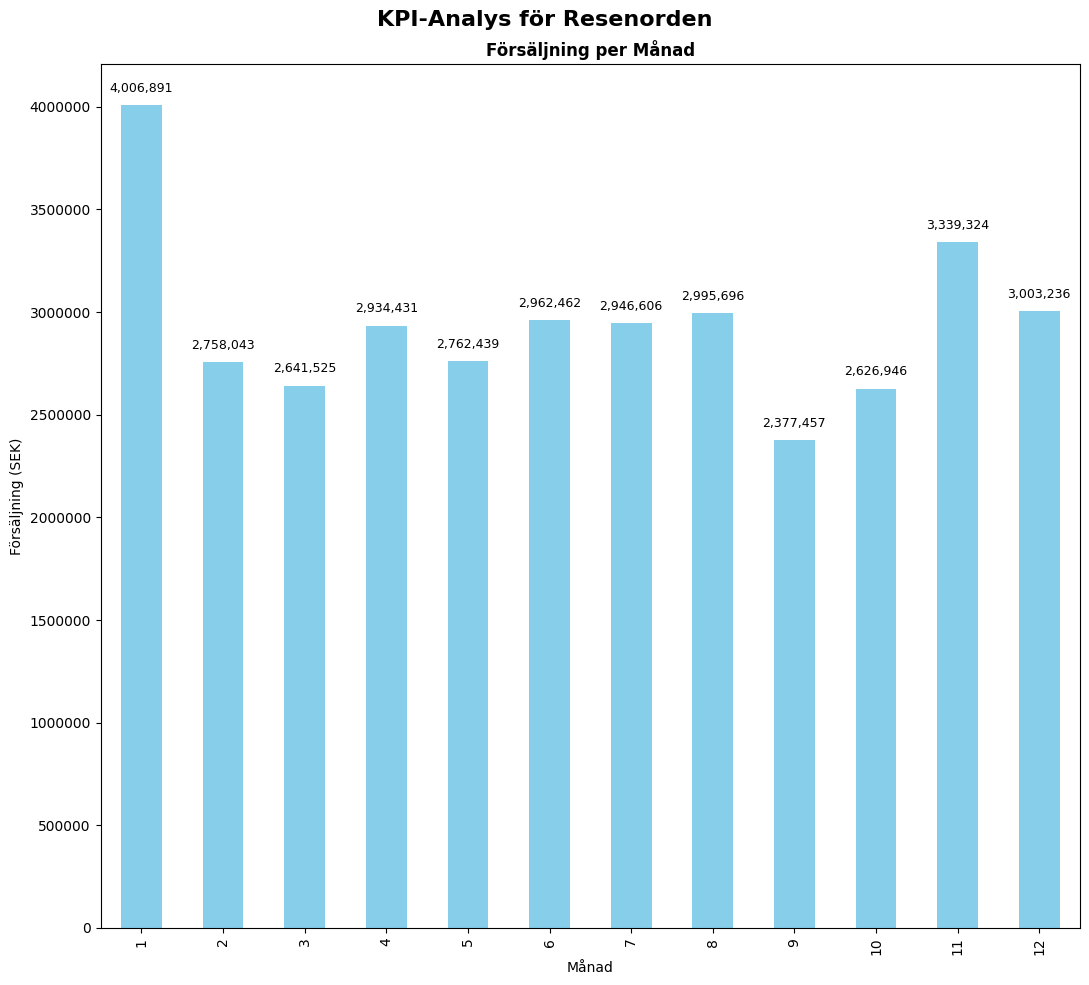

In [129]:
# Skapa figuren med bara 1 diagram
fig, ax1 = plt.subplots(1, 1, figsize=(11, 10))
fig.suptitle('KPI-Analys för Resenorden', fontsize=16, fontweight='bold')

# 1. Försäljning per månad
månads_försäljning.plot(kind='bar', color='skyblue', ax=ax1)
ax1.set_title('Försäljning per Månad', fontweight='bold')
ax1.set_xlabel('Månad')
ax1.set_ylabel('Försäljning (SEK)')
ax1.ticklabel_format(style='plain', axis='y')

# Lägg till värden ovanpå staplarna
for i, v in enumerate(månads_försäljning):
    ax1.text(i, v + 50000, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

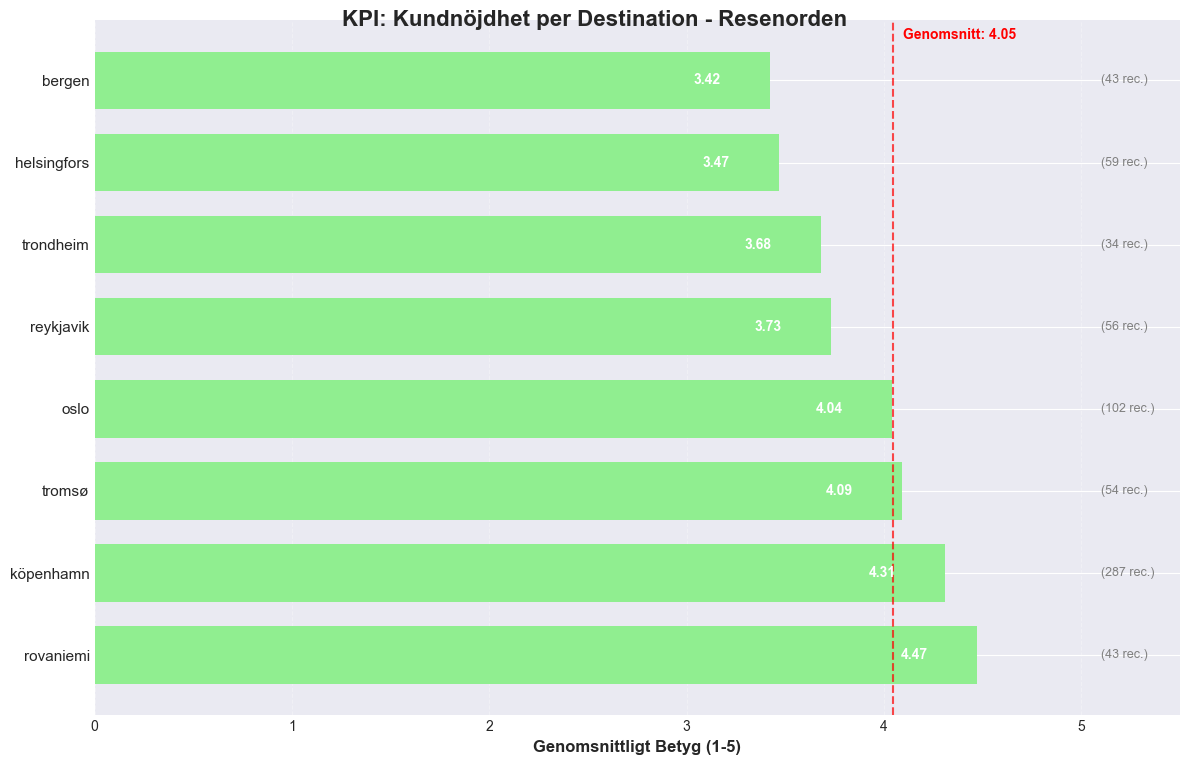

In [ ]:
# Skapa ett stort diagram (1x1)
fig, ax3 = plt.subplots(1, 1, figsize=(12, 8))

# Titel för hela figuren
fig.suptitle('KPI: Kundnöjdhet per Destination - Resenorden', 
             fontsize=16, fontweight='bold', y=0.95)

# Förbered data
top_dests = rating_by_dest[rating_by_dest['count'] >= 10].sort_values('mean', ascending=False)

# Kontrollera att vi har data
if len(top_dests) > 0:
    # Skapa horisontella staplar
    bars = ax3.barh(range(len(top_dests)), top_dests['mean'], color='lightgreen', height=0.7)
    
    # Lägg till antal recensioner i staplarna
    for i, (mean_val, count_val) in enumerate(zip(top_dests['mean'], top_dests['count'])):
        # Placera betyget innanför stapeln
        ax3.text(mean_val - 0.25, i, f'{mean_val:.2f}', 
                ha='right', va='center', fontweight='bold', color='white', fontsize=10)
        # Placera antalet recensioner till höger
        ax3.text(5.1, i, f'({count_val} rec.)', 
                ha='left', va='center', fontsize=9, color='gray')
    
    # Sätt destinationernas namn på y-axeln
    ax3.set_yticks(range(len(top_dests)))
    ax3.set_yticklabels(top_dests.index, fontsize=11)
    
    # Konfigurera axeln
    ax3.set_xlabel('Genomsnittligt Betyg (1-5)', fontsize=12, fontweight='bold')
    ax3.set_title('', 
                 fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlim(0, 5.5)  # Litet utrymme för antal-recensioner text
    
    # Lägg till en vertikal linje för genomsnittet
    avg_all = df_reviews['betyg'].mean() if 'df_reviews' in locals() else top_dests['mean'].mean()
    ax3.axvline(x=avg_all, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    ax3.text(avg_all + 0.05, len(top_dests) - 0.5, 
             f'Genomsnitt: {avg_all:.2f}', 
             color='red', fontsize=10, fontweight='bold')
    
    # Lägg till grid för bättre läsbarhet
    ax3.grid(True, axis='x', alpha=0.3, linestyle='--')
    
else:
    # Om ingen data finns
    ax3.text(0.5, 0.5, 'Inga destinationer med minst 10 recensioner', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Bästa Destinationerna', fontsize=14, fontweight='bold')
    ax3.set_xlabel('')
    ax3.set_ylabel('')

plt.tight_layout()
plt.show()

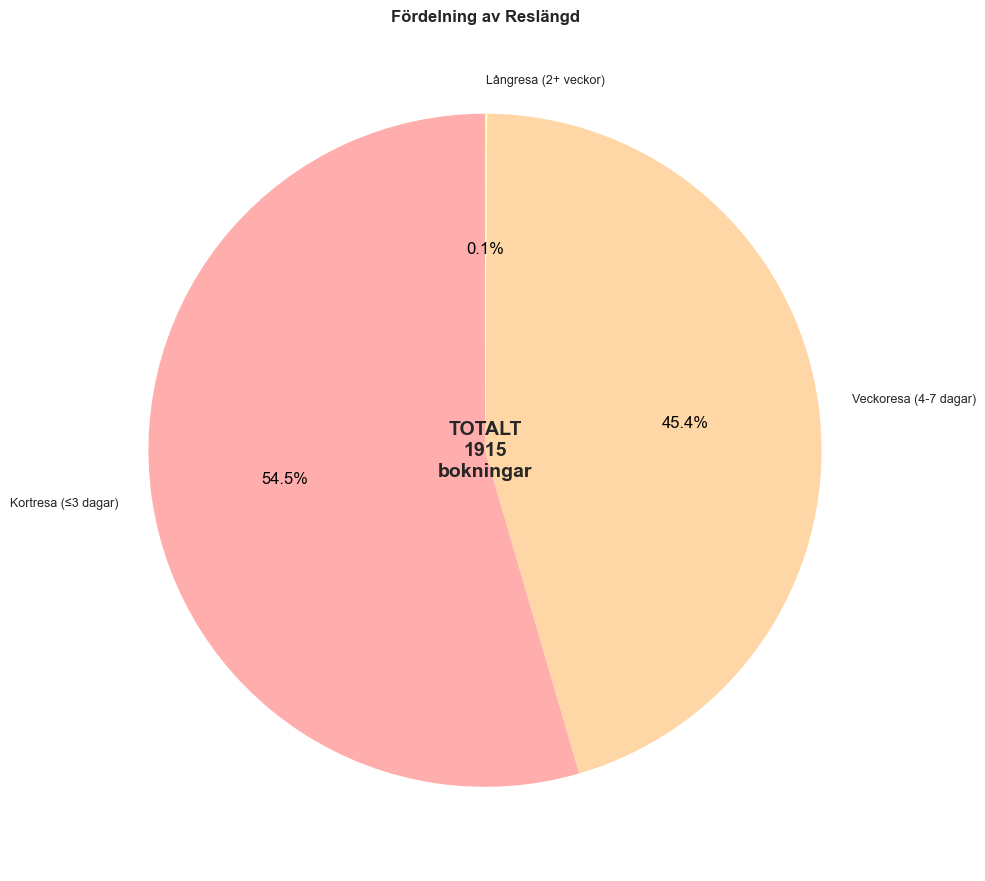

In [ ]:

# Skapa ett litet cirkeldiagram
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Förbered data
reslängd_counts = df_clean['reslängd_kategori'].value_counts()
# Skapa cirkeldiagram
wedges, texts, autotexts = ax.pie(
    reslängd_counts.values,
    labels=reslängd_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#FFADAD', '#FFD6A5', '#FDFFB6', '#CAFFBF'],
    textprops={'fontsize': 9}
)

# Gör procenttexten mer lättläst
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)

# Titel
ax.set_title('Fördelning av Reslängd', fontweight='bold', fontsize=12)


# Lägg till total i mitten
ax.text(0, 0, f'TOTALT\n{total_bookings}\nbokningar', 
        ha='center', va='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Anledning: Visualiseringar gör det enklare att förstå data. Jag har valt 3 typer av diagram:
Stapeldiagram för försäljning - visar månatliga trender tydligt
Horisontellt stapeldiagram för betyg - lätt att se rangordning
Cirkeldiagram för reslängd - visar fördelningar procentuellt